In [27]:
a = (1,2,3)
a = list(a)
a.append(4)
a

In [13]:
Lambdas = symbols('Lambda0:5')

In [14]:
Lambdas

In [3]:
from sympy import diff, lambdify, symbols, sqrt, cos, numbered_symbols, simplify, S, init_printing
from scipy.integrate import odeint
import numpy as np
init_printing()

In [7]:
rotation_matrix = np.array([[1,2],[3,1]])

In [8]:
np.dot(rotation_matrix,[S("x"),S("y")])

array([x + 2*y, 3*x + y], dtype=object)

In [2]:
import rebound
import numpy as np

def make_sim(m_res):
    logmass = -5.1
    e0 = 1.e-4 # initial eccentricity of planets
    
    sim = rebound.Simulation()
    sim.G = 4*np.pi**2
    sim.add(m=1.)
    sim.add(m=10**logmass, e=e0, P=1., hash='Earth')
    sim.add(m=10**logmass, e=e0, P=(m_res+1)/m_res)
    sim.move_to_com()
    return sim

m_res=2
Norbits = 300 # number of inner planet orbits to integrate for
Nout = 1000

sim = make_sim(m_res)

In [4]:
from celmech.hamiltonian import HamiltonianPoincare
Hp = HamiltonianPoincare()
Hp.initialize_from_sim(sim)

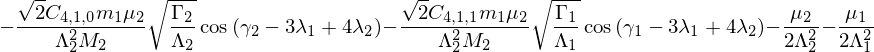

In [8]:
Hp.H

In [7]:
Hp.add_all_resonance_subterms(1,2,4,1)

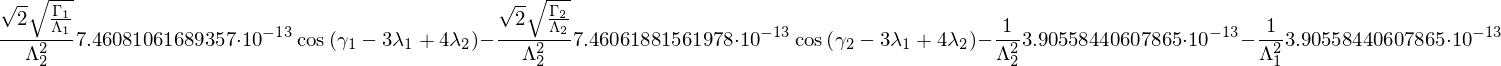

In [9]:
Hp.NH

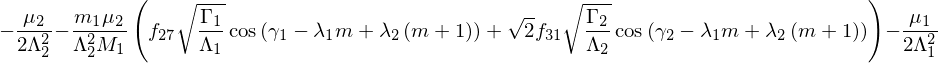

In [30]:
m2 = symbols('m2')
Hp.H.subs(m2, 3)

In [10]:
from celmech.transformations import poincare_vars_from_sim
tmax = Norbits*sim.particles[1].P
times = np.linspace(0, tmax, Nout, endpoint=False)

Nsol = np.zeros((8, Nout))
symsol = np.zeros((8, Nout))
for i, time in enumerate(times):
    sim.integrate(time)
    Hp.integrate(time)
    Nsol[:,i] = poincare_vars_from_sim(sim)
    symsol[:,i] = list(Hp.integrator.y)

/Users/samuelhadden/anaconda/lib/python2.7/site-packages/numpy/__init__.py:1: RuntimeWarning: invalid value encountered in sqrt
  """
/Users/samuelhadden/anaconda/lib/python2.7/site-packages/numpy/__init__.py:1: RuntimeWarning: invalid value encountered in sqrt
  """
/Users/samuelhadden/anaconda/lib/python2.7/site-packages/numpy/__init__.py:1: RuntimeWarning: invalid value encountered in sqrt
  """
/Users/samuelhadden/anaconda/lib/python2.7/site-packages/numpy/__init__.py:1: RuntimeWarning: invalid value encountered in sqrt
  """
/Users/samuelhadden/anaconda/lib/python2.7/site-packages/numpy/__init__.py:1: RuntimeWarning: invalid value encountered in sqrt
  """
/Users/samuelhadden/anaconda/lib/python2.7/site-packages/numpy/__init__.py:1: RuntimeWarning: invalid value encountered in sqrt
  """
celmech/transformations.py:22: RuntimeWarning: invalid value encountered in sqrt
  Lambda = mjac[i]*np.sqrt(sim.G*Mjac[i]*ps[i].a)
celmech/transformations.py:25: RuntimeWarning: invalid value enco

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15,10))
ax.set_xlabel("Time (years = inner planet orbits)", fontsize=24)
ax.set_ylabel(r"$\Lambda_1$", fontsize=24)

ax.plot(times, Nsol[0,:], '.', label='Nbody')
ax.plot(times, symsol[0,:], '.', label='Symbolic')

ax.legend()

In [10]:
#from sympy.abc import _clash2
#from sympy import sympify
#zeta = sympify('zeta', _clash2) 
theta, theta1, Theta, Theta1, zeta = symbols('theta, theta1, Theta, Theta1, {\zeta}') # need to do this trick to get zeta symbol to override sympy zeta function
#Lambda1 = Theta1 - m*Theta
#Lambda2 = (m+1)*Theta
#theta = (m+1)*lambda2 - m*lambda1
#theta1 = lambda1

In [11]:
Htheta = H.subs(Lambda1, Theta1 - m*Theta)
Htheta = Htheta.subs(Lambda2, (m+1)*Theta)
Htheta = Htheta.subs(lambda1, theta1)
Htheta = Htheta.subs(lambda2, (theta + m*theta1)/(m+1))

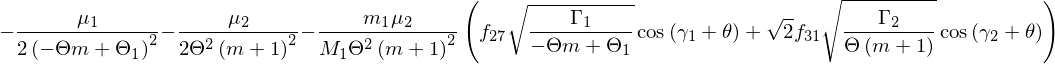

In [12]:
Htheta

In [13]:
# Actionnew = Action/Theta1, Action = Actionnew*Theta1

In [14]:
Htheta = Htheta.subs(Theta, Theta*Theta1)
Htheta = Htheta.subs(Gamma1, Gamma1*Theta1)
Htheta = Htheta.subs(Gamma2, Gamma2*Theta1)

In [15]:
Htheta /= mu2/Theta1**2
Htheta = Htheta.subs(mu1, zeta**3*mu2)
Htheta = simplify(Htheta)

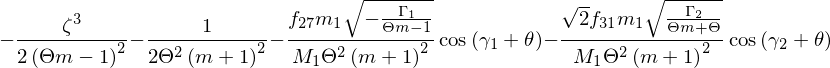

In [16]:
Htheta

In [17]:
#Lambda1, Lambda2, lambda1, lambda2, Gamma1, Gamma2, gamma1, gamma2 = S('Lambda1, Lambda2, lambda1, lambda2, Gamma1, Gamma2, gamma1, gamma2')
actionanglepairs = [(Theta, theta), (Gamma1, gamma1), (Gamma2, gamma2)]
#m1, m2, M1, mu1, mu2, alpha, m, f27, f31 = S('m1, m2, M1, mu1, mu2, alpha, m, f27, f31')
params = [m1, M1, zeta, m, f27, f31]

In [18]:
Ht = Hamiltonian(Htheta, actionanglepairs, params)

In [ ]:
def thetas_from_sim(sim, inner, outer, m, average_synodic_terms=False, scales=None):
    var, params = sim_to_poincare(sim, inner, outer, average_synodic_terms=average_synodic_terms)
    params['m'] = m
    params['zeta'] = params['mu1']/params['mu2']
    Theta = var['Lambda2']/(m+1)
    Theta1 = m/(m+1)*var['Lambda2'] + var['Lambda1']
    theta = (m+1)*var['lambda2'] - m*var['lambda1']
    theta1 = var['lambda1']
    
    if scales is None:
        scales = {'actionscale':Theta1, 'timescale':Theta1**3/params['mu2']}
    
    actionscale = scales['actionscale']
    var =  {'Theta':Theta/actionscale, 'Theta1':Theta1/actionscale, 'theta':theta, 'theta1':theta1, 'Gamma1':var['Gamma1']/actionscale, 'Gamma2':var['Gamma2']/actionscale, 'gamma1':var['gamma1'], 'gamma2':var['gamma2']}
    return var, params, scales

In [ ]:
sim = make_sim(m_res)

In [ ]:
ic, Nparams, scales = thetas_from_sim(sim, 1, 2, m_res, average_synodic_terms=True)
#m=params['m']
#alpha = params['alpha']
#f27 = 1/2*(-2*(m+1)*LaplaceCoefficient(0.5, m+1, alpha, 0) - alpha*LaplaceCoefficient(0.5, m+1, alpha, 1))
#f31 = 1/2*((2*m+1)*LaplaceCoefficient(0.5, m, alpha, 0) + alpha*LaplaceCoefficient(0.5, m, alpha, 1))        

In [ ]:
htheta = Htheta(**Nparams, f27=Nf27, f31=Nf31)

In [ ]:
htheta.symH

In [ ]:
htheta.H

In [ ]:
tmax = Norbits*sim.particles[1].P
times = np.linspace(0, tmax, Nout, endpoint=False)
timescale = scales['timescale']
normtimes = [t/timescale for t in times]
symsol = htheta.integrate(ic, normtimes)

Nsol = {'Theta':np.zeros(Nout), 'Theta1':np.zeros(Nout), 'theta':np.zeros(Nout), 'theta1':np.zeros(Nout), 
        'Gamma1':np.zeros(Nout), 'Gamma2':np.zeros(Nout), 'gamma1':np.zeros(Nout), 'gamma2':np.zeros(Nout)}
for i, time in enumerate(times):
    sim.integrate(time)
    var, Nparams, scales = thetas_from_sim(sim, 1, 2, m_res, scales=scales)
    for key in Nsol.keys():
        Nsol[key][i] = var[key]

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15,10))
ax.set_xlabel("Time (years = inner planet orbits)", fontsize=24)
ax.set_ylabel(r"$\Theta$", fontsize=24)

ax.plot(normtimes, Nsol['Theta'], '.', label='Nbody')
ax.plot(normtimes, symsol['Theta'], '.', label='Symbolic')

ax.legend()

In [ ]:
Thetabar, alpha_res = S('Thetabar, alpha_res')
Thetabar = alpha_res/m/(alpha_res + zeta)
Thetabar

In [ ]:
from sympy import series
Thetabar = Thetabar.subs(alpha_res, (m/(m+1))**(S(2)/3))
Thetabar

In [ ]:
from sympy import python
python(htheta.symH)

In [ ]:
H0 = -zeta**3/(2*(Theta*m - 1)**2) - 1/(2*Theta**2*(m + 1)**2)
H0

dH/d$\Theta$ = 0 at $\bar{\Theta}$

In [ ]:
simplify(diff(H0, Theta).subs(Theta, Thetabar))

$\beta$ = d^2H/d$\Theta^2$ at $\bar{\Theta}$ (Deck Eq. 20)

In [ ]:
beta = S('beta')
beta = (-3*m**2*(alpha_res + zeta)**5/(zeta*alpha_res))
beta

Check that it's true:

In [ ]:
simplify((diff(H0, Theta, 2)-beta.subs(alpha_res, (m/(m+1))**(S(2)/3))).subs(Theta, Thetabar))

In [ ]:
Cx0=Symbol('{C_{x_{0}}')
latex(Cx0)

In [ ]:
from sympy import symbols
dt = symbols('delta_Theta')
dt

In [ ]:
dt.name

In [ ]:
zeta = symbols('{\zeta}')
zeta

In [15]:
from sympy import Symbol
deltaTheta = Symbol('{\delta\Theta}')
deltaTheta

In [ ]:
deltaTheta.name

In [ ]:
dt = Symbol('dt')

In [ ]:
from IPython.display import display
init_printing(use_latex='mathjax')
display(latex(dt, symbol_names={dt:r'\delta\Theta'}))

Removing constant piece:

In [ ]:
Hexp,  = S('Hexp')
Hexp = beta/2

In [ ]:
H0 = -mu1/(2*Lambda1**2) - mu2/(2*Lambda2**2)
H0

In [ ]:
dL_1, dL_2 = S('dL_1, dL_2')
H0 = -mu1/(2*((2*m1/m2*sqrt(alpha) + dL_1)**2)) - mu2/(2*(2 + dL_2)**2)

In [ ]:
H0

In [ ]:
from sympy import series
series(H0, dL_1, 0, 3)

In [ ]:
series(H0, dL_2, 0, 3)